# Push Pull Implementation with Pytorch & NetworkX
The reason we use pytorch is to be able to use automatic differentiation. This makes implementing gradient based methods so much easier and more flexible. For now, because of visualization purposes, we will work in $\mathbb{R}^2$. However, everything below should work in $\mathbb{R}^n$, but you probably will have a harder time visualizing loss functions

In [1]:
import torch
import matplotlib.pyplot as plt
import networkx as nx

from objective import *
from constraint import *
from push_pull import *
from plot2d import * 

### Gradient Implementation
In push-pull (and other distributed optimization algorithms) agents can only evaluate their own gradients. Hence, it would make sense that each row of `x.grad` contains the gradients of the agent that corresponds to that row. Thus, after the calls
```
    objectives = ...
    m = MultiAgentObjective(objectives)
    obj = m(x)
    multi_backward(obj)
```

`x.grad` will contain the gradients $\nabla f_i(x_i)$. ie. `x.grad[i]` is $\nabla f_i(x_i)$. Below is a sample implementation of gradient descent for each agent simultaneously

In [2]:
n_agents = 4 
P = torch.tensor([[1, 0], 
                  [0, 1]], dtype=torch.float64, requires_grad = False)

objectives = []
for i in range(n_agents):
    xi = torch.tensor([i+1, i+1], dtype=torch.float64, requires_grad=False)
    qi = QuadraticObjective(P, xi)
    objectives.append(qi)

### Graph Implementation

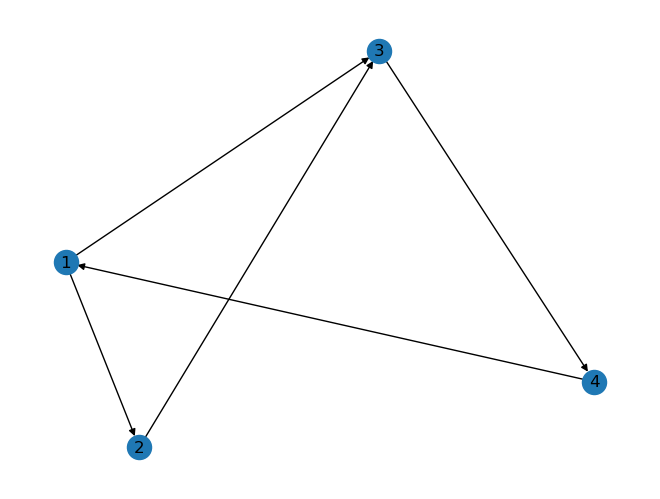

In [3]:
G = nx.DiGraph()
G.add_nodes_from(list(range(1, n_agents+1)))
G.add_edges_from([(1,2), (2,3), (3,4), (4,1), (1,3)])

A = torch.tensor(nx.to_numpy_array(G))

nx.draw(G, with_labels=True)

In [4]:
R, C = construct_RC(A)
phi, pi = find_eigenvectors(R, C)

In [5]:
x = torch.tensor([[0, 3],
                  [4, 5],
                  [10, 10],
                  [0,0]], dtype = torch.float64, requires_grad=True)

num_iterations = 15
eta = 0.1

m = MultiAgentObjective(objectives)
constraints = RectangleConstraint([[0, 2], [2,4]])

data = simulate_push_pull(R, C, m, constraints=constraints, x_init=x, eta=eta, num_iterations = num_iterations)

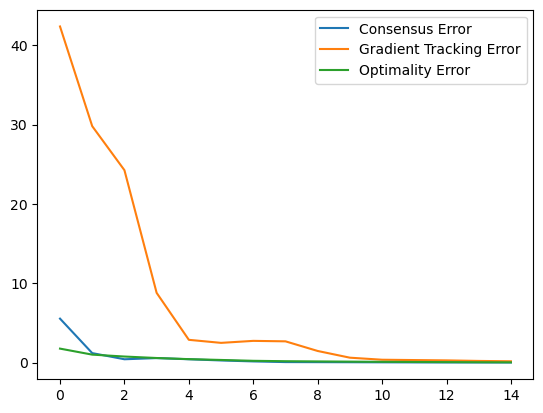

In [6]:
consensus_errors = data['consensus_error']
gradient_errors = data['grad_error']
optimality_errors = data['optimality_gap']
xs = data['xs']

plt.plot(list(range(len(consensus_errors))), consensus_errors, label='Consensus Error')
plt.plot(list(range(len(gradient_errors))), gradient_errors, label='Gradient Tracking Error')
plt.plot(list(range(len(optimality_errors))), optimality_errors, label='Optimality Error')
plt.legend()
plt.show()

In [7]:
xs= torch.stack(xs).permute(1, 0, 2)

In [9]:
print(xs.shape)

torch.Size([4, 15, 2])


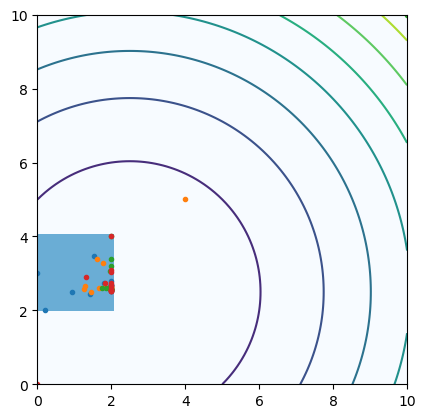

In [10]:
# determine the range for the plot
xr_min, xr_max = xs[:, :, 0].min(), xs[:, :, 0].max()
yr_min, yr_max = xs[:, :, 1].min(), xs[:, :, 1].max()


plot_problem_2d(m, constraints, rng = [[xr_min, xr_max], [yr_min, yr_max]])

#
# TODO, fix the case when the points are out of range of the problem plot
#
for i in range(n_agents):
    xi = xs[i][:, 0]
    yi = xs[i][:, 1]
    plt.plot(xi, yi, '.')

plt.show()